# Prepare environment

In [1]:
import scanpy as sc, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn.metrics as skm
import yaml

warnings.filterwarnings("ignore")

samples_map = {"CMO301": "CTL01A",
               "CMO302": "CTL02A",
               "CMO303": "CTL04E",
               "CMO304": "CTL08A",
               "CMO305": "CTL01A",
               "CMO306": "CTL02A",
               "CMO307": "CTL04E",
               "CMO308":"CTL08A",
               "Doublet": "Doublet",
               "Negative": "Negative",
               "Multiplet": "Doublet",
               "Unassigned": "Negative",
               
              }

old_names_map = {"809": "CTL04E",
                 "KOLF": "CTL08A",
                 "MIFF1": "CTL02A",
                 "3391B": "CTL01A",
                 "DBL": "Doublet",
                 "Doublet": "Doublet",
                 "unassigned": "Negative",
                 "Unassigned": "Negative",
                 "doublet": "Doublet",
                 "Multiplet": "Doublet",
                 "LowQuality": "Negative"
    
}


multiseq_gen_map = {"CMO301": "CTL01A",
                    "CMO302": "CTL02A",
                    "CMO303": "CTL04E",
                    "CMO304": "CTL08A",
                    "Doublet": "Doublet",
                    "Negative": "Negative" 
    
}

souporcell_map = {"0":"CTL01A",
                  "1":"CTL08A",
                  "2": "CTL02A",
                  "3": "CTL04E",
                  "doublet": "Doublet",
                  "unassigned": "Negative"
    
}

exposures_palette = {"CTL01A":"#DBB807",
                     "CTL08A":"#0FB248",
                     "CTL04E":"#FF0054",
                     "CTL02A":"#7B00FF",
                     "Doublet":"#403b3b",
                     "Negative":"#a8a5a5"
                    }

sd_palette = {"singlet":"#282f9c",
             "doublet":"#403b3b",
             "GoodQuality":"#29c429",
             "LowQuality":"#a8a5a5"}


colors_dict = {
"demux_v2_call": "blue",
"scansnp_call":"yellow",
"scansnp_w_neg": "orange",
"souporcell_call": "green",
"vireo_call":"red",
"Consensus":"cyan"
              }

order = list(exposures_palette.keys())

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


## Inputs folders

In [2]:
import os
homeDir = os.getenv("HOME")

MS_class = homeDir+"/data/cellplexDS/MultiSeqResults/116_Classification.csv"

genDem_folder = homeDir+"/data/cellplexDS/geneticDemultiplexing/results/class_tables/"


if not os.path.exists(homeDir+"/data/cellplexDS/adatas"):
   # Create a new directory because it does not exist
   os.makedirs(homeDir+"/data/cellplexDS/adatas")


## Initialize functions and objects

In [3]:
dbl_rate = {}
unassigned_rate = {}

# Load anndata
We load the raw matrix from `cellranger multi` and subset it according to the cell barcodes called as non-empty by the algorithm.

In [4]:
sample1_adata_raw = sc.read_10x_h5(homeDir+"/data/cellplexDS/alignment/test1/outs/multi/count/raw_feature_bc_matrix.h5")
sample1_adata_raw

reading /group/testa/Users/davide.castaldi/organoidMultiplexing_release/data/cellplexDS/alignment/test1/outs/multi/count/raw_feature_bc_matrix.h5


 (0:00:10)


AnnData object with n_obs × n_vars = 3590455 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
CR_class = pd.read_csv(homeDir+"/data/cellplexDS/alignment/test1/outs/multi/multiplexing_analysis/assignment_confidence_table.csv", index_col = "Barcodes")
CR_class

,Row,CMO301,CMO302,CMO303,CMO304,Multiplet,Blanks,Assignment,Assignment_Probability
Barcodes,,,,,,,,,
AAACCCAAGATGCTGG-1,0,5.728910e-11,9.401407e-01,2.980659e-05,1.103714e-12,0.059818,1.114560e-05,CMO302,0.940141
AAACCCAAGCAAACAT-1,1,3.582631e-08,3.537087e-04,9.726013e-01,2.309623e-07,0.000306,2.673885e-02,CMO303,0.972601
AAACCCAAGCTACAAA-1,2,2.646026e-13,8.960614e-14,1.209593e-09,9.520157e-01,0.047984,5.711508e-10,CMO304,0.952016
AAACCCAAGGCGTCCT-1,3,4.801895e-04,1.278654e-09,5.418507e-13,1.291917e-19,0.999520,2.248304e-14,Multiplet,0.999520
AAACCCAAGTAGTCAA-1,4,3.489225e-01,6.953636e-14,2.623145e-09,3.820114e-17,0.651078,3.328542e-11,Unassigned,0.651078
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCGCACGAC-1,22421,9.516743e-01,1.855442e-08,2.504661e-04,4.273720e-09,0.047957,1.182661e-04,CMO301,0.951674
TTTGTTGTCGCCATAA-1,22422,9.329486e-01,3.704943e-11,7.802441e-08,6.242059e-13,0.067051,2.584258e-08,CMO301,0.932949
TTTGTTGTCTACTGCC-1,22423,6.430967e-11,9.369841e-01,1.441847e-05,5.838203e-11,0.062996,5.102356e-06,CMO302,0.936984


In [6]:
sample1_adata = sample1_adata_raw[CR_class.index.tolist()]

# we save the "assignment_confidence_table.csv" in the obs so we have the assignment
sample1_adata.obs = CR_class

In [7]:
sample1_adata

AnnData object with n_obs × n_vars = 22426 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
sample1_adata.obs["Assignment"] = sample1_adata.obs["Assignment"].map(samples_map)
sample1_adata.obs["Assignment"].value_counts()

Assignment
Negative    5586
CTL04E      4057
CTL01A      3757
CTL08A      3670
CTL02A      3522
Doublet     1560
Name: count, dtype: int64

In [9]:
# check if there are any nans in the Assignment column
CR_NaNs = sample1_adata[sample1_adata.obs["Assignment"].isna()].obs_names
len(CR_NaNs)

274

In [10]:
sample1_adata.write(homeDir+"/data/cellplexDS/adatas/test1_raw.h5ad")
sample1_adata = sc.read(homeDir+"/data/cellplexDS/adatas/test1_raw.h5ad")

Now we load the filtered count matrix from the `cellranger count` alignment:

In [11]:
sample1_adata_count = sc.read_10x_h5(homeDir+"/data/cellplexDS/alignment/test1_count/outs/filtered_feature_bc_matrix.h5")
sample1_adata_count

reading /group/testa/Users/davide.castaldi/organoidMultiplexing_release/data/cellplexDS/alignment/test1_count/outs/filtered_feature_bc_matrix.h5
 (0:00:03)


AnnData object with n_obs × n_vars = 21989 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

`cellranger count` and `cellranger multi` don"t call exactly the same cells as non-empty, so I"m detecting how many cell barcodes are not in common:

In [12]:
len(set(sample1_adata_count.obs_names).difference(set(sample1_adata.obs_names)))

2

In [13]:
len(set(sample1_adata.obs_names).difference(set(sample1_adata_count.obs_names)))

439

I"m filtering out the few cells that are not called by both cellranger multi and cellranger count:

In [14]:
len(set(sample1_adata_count.obs_names).intersection(set(sample1_adata.obs_names)))

21987

In [15]:
sample1_adata = sample1_adata[list(set(sample1_adata_count.obs_names).intersection(set(sample1_adata.obs_names)).difference(set(CR_NaNs)))]
sample1_adata

View of AnnData object with n_obs × n_vars = 21721 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

## Evaluation of cellranger multi classification

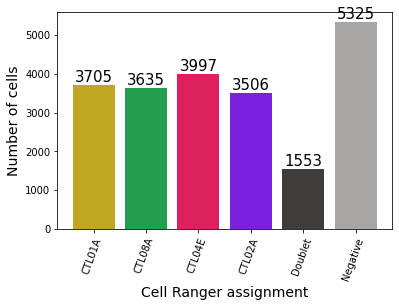

In [16]:
order_new = order.copy()
#order_new.remove("Negative")
#order_new.remove("Doublet")

fig, ax = plt.subplots()

sns.barplot(y = sample1_adata.obs.Assignment.value_counts().loc[order_new].values, ax = ax,
            x = sample1_adata.obs.Assignment.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = sample1_adata.obs.Assignment.value_counts().loc[order_new].index.to_list()
values = sample1_adata.obs.Assignment.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

plt.xlabel("Cell Ranger assignment", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

Percentage of identities:

In [17]:
norm = sample1_adata.obs.Assignment.value_counts().loc[order_new] / sample1_adata.shape[0] * 100
norm

Assignment
CTL01A      17.057226
CTL08A      16.734957
CTL04E      18.401547
CTL02A      16.141062
Doublet      7.149763
Negative    24.515446
Name: count, dtype: float64

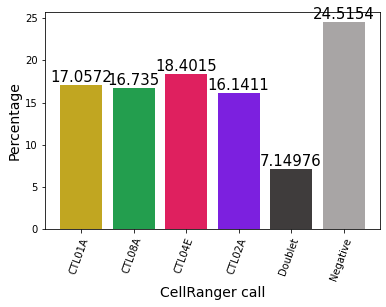

In [18]:
fig, ax = plt.subplots()

sns.barplot(y = norm.values, ax = ax,
            x = norm.index.to_list(), palette=exposures_palette)

labels = norm.index.to_list()
values = norm.values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("CellRanger call", size=14)
plt.ylabel("Percentage", size=14)
plt.show()

## Evaluation of MultiSeq classification

In [19]:
multi_seq_class_1 = pd.read_csv(MS_class, index_col = 0)
multi_seq_class_1.columns = ["MultiSeq_call"]
multi_seq_class_1.MultiSeq_call = multi_seq_class_1.MultiSeq_call.map(multiseq_gen_map)
multi_seq_class_1.MultiSeq_call.value_counts()

MultiSeq_call
Negative    4443
CTL01A      3807
CTL08A      3691
CTL04E      3661
CTL02A      3535
Doublet     3289
Name: count, dtype: int64

In [20]:
multi_seq_class_1.shape

(22426, 1)

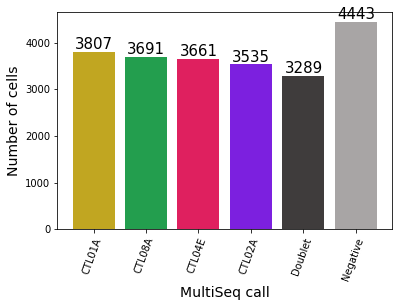

In [21]:
fig, ax = plt.subplots()

sns.barplot(y = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].values, ax = ax,
            x = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].index.to_list()
values = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("MultiSeq call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

Percentages of identities

In [22]:
norm = multi_seq_class_1.MultiSeq_call.value_counts().loc[order] / multi_seq_class_1.shape[0] * 100
norm

MultiSeq_call
CTL01A      16.975832
CTL08A      16.458575
CTL04E      16.324802
CTL02A      15.762954
Doublet     14.666013
Negative    19.811826
Name: count, dtype: float64

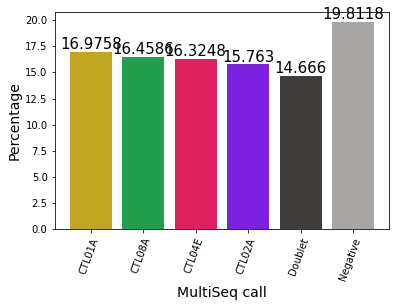

In [23]:
norm = multi_seq_class_1.MultiSeq_call.value_counts().loc[order] / multi_seq_class_1.shape[0] * 100
norm

fig, ax = plt.subplots()

sns.barplot(y = norm.values, ax = ax,
            x = norm.index.to_list(), palette=exposures_palette)

labels = norm.index.to_list()
values = norm.values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("MultiSeq call", size=14)
plt.ylabel("Percentage", size=14)
plt.show()

## Comparison of CellRanger and MultiSeq

In [24]:
df_all_class_sample1 = multi_seq_class_1.merge(sample1_adata.obs.Assignment, how = "inner", left_index = True, right_index = True)
df_all_class_sample1.columns = ["MultiSeq_call", "CellR_call"]
pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["CellR_call"])

CellR_call,CTL01A,CTL02A,CTL04E,CTL08A,Doublet,Negative
MultiSeq_call,,,,,,
CTL01A,3686,0,0,0,0,68
CTL02A,0,3486,0,0,0,32
CTL04E,0,0,3607,0,0,16
CTL08A,0,0,0,3605,0,51
Doublet,19,20,5,29,1553,1645
Negative,0,0,385,1,0,3513


## Genetic demultiplexing
In this section, we load and evaluate the results from each algorithm used in the aggregating pipeline

### Demuxlet v1

In [25]:
demuxlet_v1_sample1 = pd.read_csv(genDem_folder + "test01/demuxlet_v1/test01.best", sep = "\t", index_col = 0)
demuxlet_v1_sample1

,RD.TOTL,RD.PASS,RD.UNIQ,N.SNP,BEST,SNG.1ST,SNG.LLK1,SNG.2ND,SNG.LLK2,SNG.LLK0,...,DBL.2ND,ALPHA,LLK12,LLK1,LLK2,LLK10,LLK20,LLK00,PRB.DBL,PRB.SNG1
BARCODE,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGCTGG-1,26049,1226,1133,634,SNG-MIFF1,MIFF1,-394.1724,809,-1504.6661,-446.6411,...,MIFF1,0.5,-466.6797,-1504.6661,-394.1724,-1251.6351,-487.8520,-455.2773,2.200000e-33,1.000
AAACCCAAGCAAACAT-1,32586,1616,1466,872,SNG-809,809,-423.0393,KOLF,-1570.0551,-448.3416,...,809,0.5,-480.3834,-1648.4264,-423.0393,-1649.5271,-480.3834,-468.9705,8.450000e-27,1.000
AAACCCAAGCTACAAA-1,37489,2721,2553,1337,SNG-KOLF,KOLF,-638.9583,809,-2195.0596,-723.4253,...,KOLF,0.5,-704.1465,-2195.0596,-638.9583,-1732.3206,-784.0192,-741.6592,3.310000e-30,1.000
AAACCCAAGGCGTCCT-1,44271,1811,1644,917,DBL-809-MIFF1-0.500,809,-1084.6131,MIFF1,-1633.4858,-656.9232,...,MIFF1,0.5,-525.2326,-1084.6131,-1633.4858,-946.6220,-830.1021,-559.9087,1.000000e+00,1.000
AAACCCAAGTAGTCAA-1,143157,4224,3868,1822,DBL-3391B-809-0.500,809,-1916.0358,3391B,-2054.9581,-1060.0271,...,809,0.5,-874.6085,-2054.9581,-1916.0358,-2057.0195,-874.6085,-976.6761,1.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCGCACGAC-1,22203,491,450,378,DBL-3391B-809-0.500,3391B,-166.1637,809,-440.2660,-178.8775,...,809,0.5,-148.0075,-166.1637,-440.2660,-166.4213,-148.0075,-174.9884,1.000000e+00,1.000
TTTGTTGTCGCCATAA-1,19203,1500,1386,647,SNG-3391B,3391B,-348.1912,809,-1095.4014,-389.4511,...,809,0.5,-382.3611,-348.1912,-1095.4014,-348.7297,-382.3611,-373.1082,9.800000e-17,1.000
TTTGTTGTCTACTGCC-1,21738,807,746,496,SNG-MIFF1,MIFF1,-234.5121,809,-1145.2373,-312.8114,...,MIFF1,0.5,-309.0250,-1325.6665,-234.5121,-979.3407,-312.5560,-321.7451,3.050000e-34,1.000


In [26]:
demuxlet_v1_sample1["doubletState"] = demuxlet_v1_sample1["BEST"].apply(lambda x: x.split("-")[0])
demuxlet_v1_sample1["doubletState"].value_counts()

doubletState
SNG    12005
DBL     9983
AMB        1
Name: count, dtype: int64

In [27]:
demuxlet_v1_sample1["demux_v1_call"] = demuxlet_v1_sample1["BEST"].apply(lambda x: x.split("-")[1] if "DBL" not in x else ("DBL"))
demuxlet_v1_sample1["demux_v1_call"].value_counts()

demux_v1_call
DBL      9983
809      3463
MIFF1    3115
KOLF     2976
3391B    2452
Name: count, dtype: int64

In [28]:
df_all_class_sample1 = df_all_class_sample1.merge(demuxlet_v1_sample1["demux_v1_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample1["demux_v1_call"] = df_all_class_sample1["demux_v1_call"].map(old_names_map)

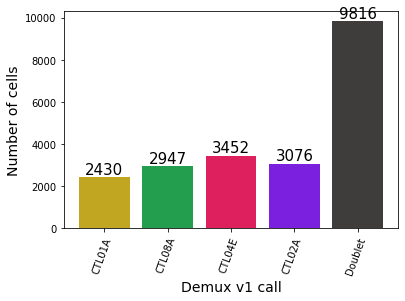

In [29]:
order_new = order.copy()
order_new.remove("Negative")

fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.demux_v1_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample1.demux_v1_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.demux_v1_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample1.demux_v1_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Demux v1 call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='demux_v1_call', ylabel='MultiSeq_call'>

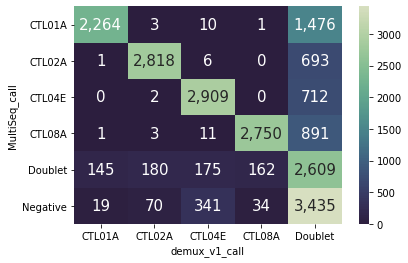

In [30]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["demux_v1_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='demux_v1_call', ylabel='CellR_call'>

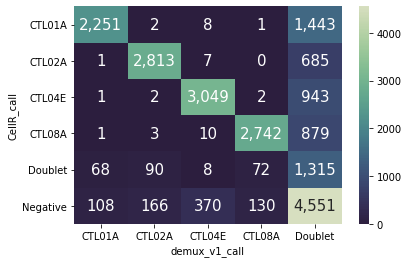

In [31]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["demux_v1_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Demuxlet v2

In [32]:
demuxlet_v2_sample1 = pd.read_csv(genDem_folder + "test01/demuxlet_v2/test01.best", sep = "\t", index_col = 1)
demuxlet_v2_sample1

,INT_ID,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
BARCODE,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGCTGG-1,0,592,860,SNG,"MIFF1,MIFF1,0.00",-283.36,"809,MIFF1,0.50",-337.97,54.61,-2.900000e+02,1,MIFF1,-283.36,809,-600.10,0.0,"809,MIFF1,0.50",-337.97,54.61
AAACCCAAGCAAACAT-1,1,815,1142,SNG,"809,809,0.00",-327.71,"809,KOLF,0.50",-395.82,68.12,-3.300000e+02,1,809,-327.71,KOLF,-623.19,0.0,"809,KOLF,0.50",-395.82,68.12
AAACCCAAGCTACAAA-1,2,1271,2298,SNG,"KOLF,KOLF,0.00",-469.54,"809,KOLF,0.50",-599.99,130.45,-4.700000e+02,1,KOLF,-469.54,809,-985.84,0.0,"809,KOLF,0.50",-599.99,130.45
AAACCCAAGGCGTCCT-1,3,848,1312,DBL,"809,MIFF1,0.50",-428.06,"MIFF1,809,0.50",-428.06,0.00,1.000000e-187,1,809,-556.12,MIFF1,-621.50,0.0,"809,MIFF1,0.50",-428.06,-128.06
AAACCCAAGTAGTCAA-1,4,1711,2896,DBL,"3391B,809,0.50",-794.29,"809,3391B,0.50",-794.29,0.00,0.000000e+00,1,3391B,-1019.86,809,-1040.96,0.0,"3391B,809,0.50",-794.29,-225.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCGCACGAC-1,21984,346,394,SNG,"3391B,3391B,0.00",-124.67,"809,3391B,0.50",-137.22,12.55,-1.300000e+02,1,3391B,-124.67,809,-224.78,0.0,"809,3391B,0.50",-137.22,12.55
TTTGTTGTCGCCATAA-1,21985,593,979,SNG,"3391B,3391B,0.00",-272.27,"3391B,809,0.50",-306.22,33.95,-2.700000e+02,1,3391B,-272.27,809,-513.54,0.0,"3391B,809,0.50",-306.22,33.95
TTTGTTGTCTACTGCC-1,21986,458,606,SNG,"MIFF1,MIFF1,0.00",-183.18,"KOLF,MIFF1,0.50",-236.16,52.98,-1.900000e+02,1,MIFF1,-183.18,809,-439.24,0.0,"KOLF,MIFF1,0.50",-236.16,52.98


In [33]:
demuxlet_v2_sample1["demux_v2_call"] = [demuxlet_v2_sample1.loc[i, "DROPLET.TYPE"] if demuxlet_v2_sample1.loc[i, "DROPLET.TYPE"] == "DBL" else demuxlet_v2_sample1.loc[i, "SNG.BEST.GUESS"] for i in demuxlet_v2_sample1.index] 
demuxlet_v2_sample1["demux_v2_call"].value_counts()

demux_v2_call
DBL      5512
809      4715
MIFF1    3958
3391B    3911
KOLF     3893
Name: count, dtype: int64

In [34]:
# saving the doublets rate and unassigned rate
dbl_rate["Demuxlet"] = np.sum(demuxlet_v2_sample1["demux_v2_call"] == "DBL") / demuxlet_v2_sample1.shape[0]
dbl_rate

{'Demuxlet': 0.25067078994042474}

In [35]:
unassigned_rate["Demuxlet"] = 0
unassigned_rate

{'Demuxlet': 0}

In [36]:
df_all_class_sample1 = df_all_class_sample1.merge(demuxlet_v2_sample1["demux_v2_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample1["demux_v2_call"] = df_all_class_sample1["demux_v2_call"].map(old_names_map)

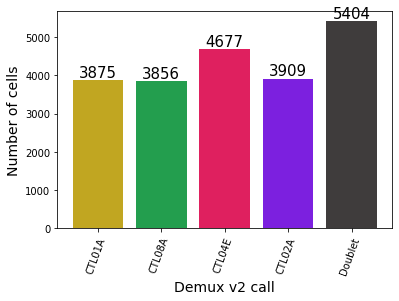

In [37]:
order_new = order.copy()
order_new.remove("Negative")

fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.demux_v2_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample1.demux_v2_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.demux_v2_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample1.demux_v2_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Demux v2 call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='demux_v2_call', ylabel='MultiSeq_call'>

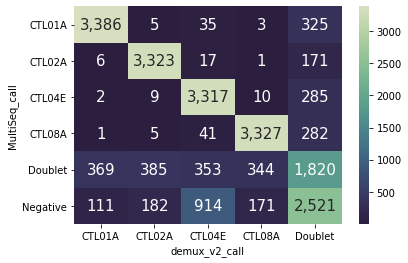

In [38]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["demux_v2_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='demux_v2_call', ylabel='CellR_call'>

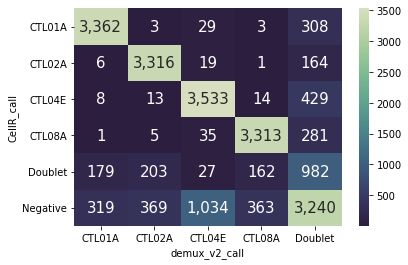

In [39]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["demux_v2_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### SCanSNP

In [40]:
scansnp_sample1 = pd.read_csv(genDem_folder + "test01/scansnp/Cell_IDs.tsv", sep = "\t", index_col = 0)
scansnp_sample1["scansnp_call"] = scansnp_sample1["ID"].map(old_names_map)
scansnp_sample1["scansnp_call_quality"] = scansnp_sample1["ID"].map(old_names_map) + "_" + scansnp_sample1["Quality"]
dbl_rate["SCanSNP"] = np.sum(scansnp_sample1["Quality"] == "Doublet") / scansnp_sample1.shape[0]
dbl_rate

{'Demuxlet': 0.25067078994042474, 'SCanSNP': 0.1077356860248306}

In [41]:
unassigned_rate["SCanSNP"] = 0
unassigned_rate

{'Demuxlet': 0, 'SCanSNP': 0}

In [42]:
df_all_class_sample1 = df_all_class_sample1.merge(scansnp_sample1["scansnp_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample1 = df_all_class_sample1.merge(scansnp_sample1["scansnp_call_quality"], how = "inner", left_index = True, right_index = True)
df_all_class_sample1 = df_all_class_sample1.merge(scansnp_sample1["Quality"], how = "inner", left_index = True, right_index = True)
df_all_class_sample1["scansnp_w_neg"] = np.where(df_all_class_sample1["Quality"] == "LowQuality", "Negative", df_all_class_sample1.scansnp_call)
df_all_class_sample1.shape

(21721, 8)

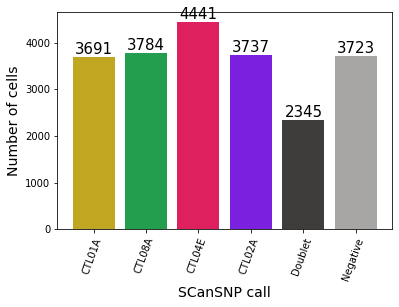

In [43]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.scansnp_w_neg.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample1.scansnp_w_neg.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.scansnp_w_neg.value_counts().loc[order].index.to_list()
values = df_all_class_sample1.scansnp_w_neg.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SCanSNP call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

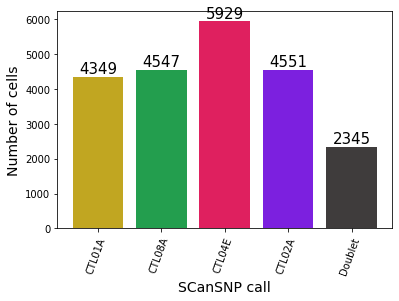

In [44]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.scansnp_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample1.scansnp_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.scansnp_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample1.scansnp_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SCanSNP call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

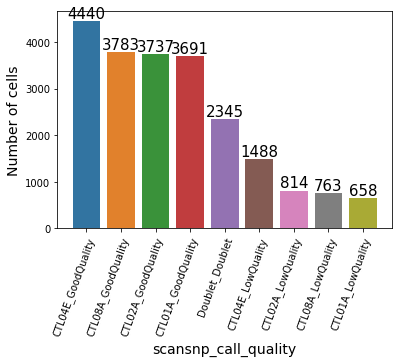

In [45]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.scansnp_call_quality.value_counts().values, ax = ax,
            x = df_all_class_sample1.scansnp_call_quality.value_counts().index.to_list())

labels = np.unique(df_all_class_sample1.scansnp_call_quality[~df_all_class_sample1.scansnp_call_quality.isna()])
values = df_all_class_sample1.scansnp_call_quality.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

plt.xlabel("scansnp_call_quality", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

In [46]:
df_all_class_sample1["scansnp_call_lowquality"] = df_all_class_sample1["scansnp_call_quality"]

<AxesSubplot: xlabel='scansnp_w_neg', ylabel='MultiSeq_call'>

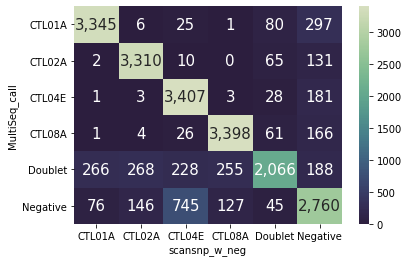

In [47]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["scansnp_w_neg"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Quality', ylabel='MultiSeq_call'>

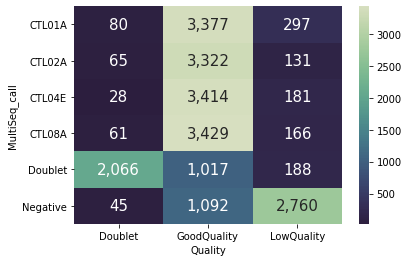

In [48]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["Quality"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='scansnp_w_neg', ylabel='CellR_call'>

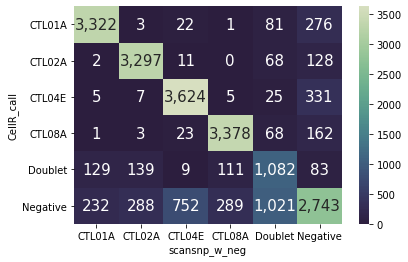

In [49]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["scansnp_w_neg"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Quality', ylabel='CellR_call'>

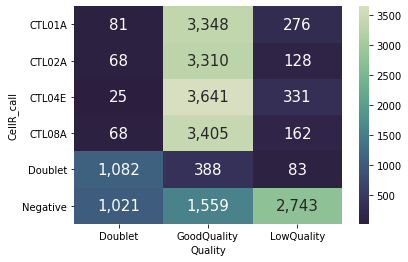

In [50]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["Quality"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Souporcell

In [51]:
souporcell_sample1 = pd.read_csv(genDem_folder + "test01/souporcell/clusters.tsv", sep = "\t", index_col = 0)
souporcell_sample1

,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2,cluster3
barcode,,,,,,,,
AAACCCAAGATGCTGG-1,singlet,2,-794.947935,-1012.109994,-1963.412035,-1979.184485,-794.947935,-2023.418065
AAACCCAAGCAAACAT-1,singlet,3,-915.611212,-1139.030792,-2040.607872,-2039.592121,-2478.268257,-915.611212
AAACCCAAGCTACAAA-1,singlet,1,-908.583243,-1232.547615,-2175.519244,-908.583243,-2562.259546,-2187.730117
AAACCCAAGGCGTCCT-1,doublet,2/3,-2422.374698,-1883.629649,-3250.544994,-3363.586992,-2422.374698,-2624.313628
AAACCCAAGTAGTCAA-1,doublet,3/0,-5846.390447,-5214.394473,-7171.661391,-8698.039816,-10342.072154,-5846.390447
...,...,...,...,...,...,...,...,...
TTTGTTGTCGCACGAC-1,singlet,0,-738.233405,-910.564203,-738.233405,-1458.182008,-1655.419685,-1377.985432
TTTGTTGTCGCCATAA-1,singlet,0,-438.555004,-546.183148,-438.555004,-1008.660902,-1271.512112,-1106.949316
TTTGTTGTCTACTGCC-1,singlet,2,-689.097367,-884.525389,-1653.792782,-1721.029029,-689.097367,-1760.105191


In [52]:
souporcell_sample1["souporcell_call"] = [souporcell_sample1.loc[i, "status"] if (souporcell_sample1.loc[i, "status"] == "doublet") or (souporcell_sample1.loc[i, "status"] == "unassigned") else souporcell_sample1.loc[i, "assignment"] for i in souporcell_sample1.index]
souporcell_sample1[["status", "souporcell_call"]].value_counts()

status      souporcell_call
doublet     doublet            4930
singlet     3                  4431
            0                  4106
            1                  3960
            2                  3948
unassigned  unassigned          614
Name: count, dtype: int64

In [53]:
dbl_rate["SoC"] = np.sum(souporcell_sample1["status"] == "doublet") / souporcell_sample1.shape[0]
dbl_rate

{'Demuxlet': 0.25067078994042474,
 'SCanSNP': 0.1077356860248306,
 'SoC': 0.2242030105962072}

In [54]:
unassigned_rate["SoC"] = np.sum(souporcell_sample1["status"] == "unassigned") / souporcell_sample1.shape[0]
unassigned_rate

{'Demuxlet': 0, 'SCanSNP': 0, 'SoC': 0.027923052435308564}

In [55]:
df_all_class_sample1 = df_all_class_sample1.merge(souporcell_sample1["souporcell_call"].map(souporcell_map), how = "inner", left_index = True, right_index = True)

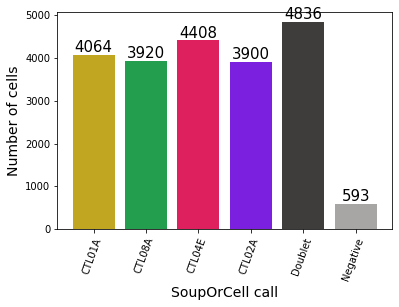

In [56]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.souporcell_call.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample1.souporcell_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.souporcell_call.value_counts().loc[order].index.to_list()
values = df_all_class_sample1.souporcell_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SoupOrCell call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='souporcell_call', ylabel='MultiSeq_call'>

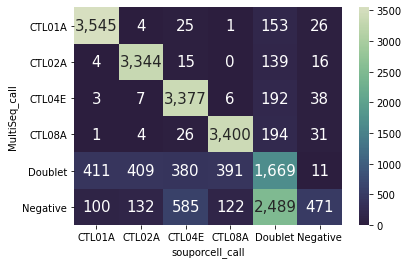

In [57]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["souporcell_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='souporcell_call', ylabel='CellR_call'>

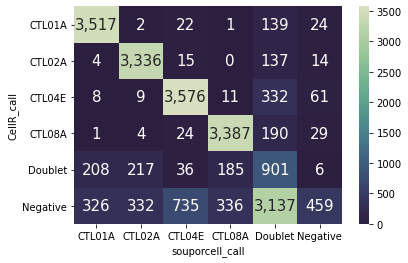

In [58]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["souporcell_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Vireo

In [59]:
vireo_sample1 = pd.read_csv(genDem_folder + "test01/vireo/vireo_out/donor_ids.tsv", sep = "\t", index_col = 0)
vireo_sample1

,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet
cell,,,,,,
AAACCCAAGATGCTGG-1,MIFF1,1.000000e+00,4.000000e-99,461,MIFF1,"3391B,MIFF1"
AAACCCAAGCAAACAT-1,809,1.000000e+00,1.490000e-61,585,809,"3391B,809"
AAACCCAAGCTACAAA-1,KOLF,1.000000e+00,1.640000e-107,847,KOLF,"809,3391B"
AAACCCAAGGCGTCCT-1,doublet,1.180000e-42,1.000000e+00,589,809,"809,KOLF"
AAACCCAAGTAGTCAA-1,doublet,2.600000e-160,1.000000e+00,1086,3391B,"3391B,809"
...,...,...,...,...,...,...
TTTGTTGTCGCACGAC-1,3391B,1.000000e+00,1.450000e-14,274,3391B,"3391B,809"
TTTGTTGTCGCCATAA-1,3391B,1.000000e+00,3.670000e-47,457,3391B,"3391B,809"
TTTGTTGTCTACTGCC-1,MIFF1,1.000000e+00,7.660000e-55,347,MIFF1,"809,KOLF"


In [60]:
vireo_sample1["vireo_call"] = vireo_sample1["donor_id"].map(old_names_map)
vireo_sample1["vireo_call"].value_counts()

vireo_call
CTL04E      4520
Doublet     3944
CTL02A      3935
CTL08A      3928
CTL01A      3922
Negative    1740
Name: count, dtype: int64

In [61]:
dbl_rate["Vireo"] = np.sum(vireo_sample1["vireo_call"] == "Doublet") / vireo_sample1.shape[0]
dbl_rate

{'Demuxlet': 0.25067078994042474,
 'SCanSNP': 0.1077356860248306,
 'SoC': 0.2242030105962072,
 'Vireo': 0.17936240847696575}

In [62]:
unassigned_rate["Vireo"] = np.sum(vireo_sample1["vireo_call"] == "Negative") / vireo_sample1.shape[0]
unassigned_rate

{'Demuxlet': 0,
 'SCanSNP': 0,
 'SoC': 0.027923052435308564,
 'Vireo': 0.07913047432807313}

In [63]:
df_all_class_sample1 = df_all_class_sample1.merge(vireo_sample1["vireo_call"], how = "inner", left_index = True, right_index = True)

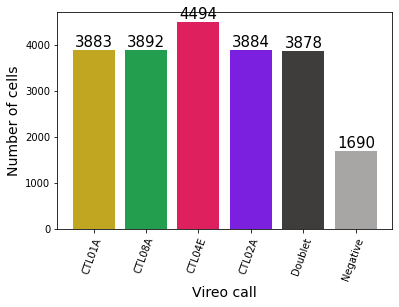

In [64]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.vireo_call.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample1.vireo_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.vireo_call.value_counts().loc[order].index.to_list()
values = df_all_class_sample1.vireo_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Vireo call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='vireo_call', ylabel='MultiSeq_call'>

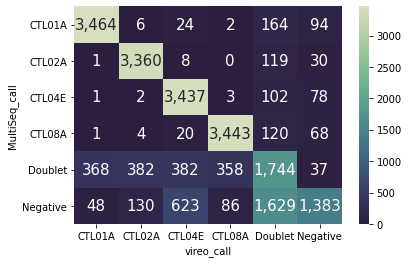

In [65]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["vireo_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='vireo_call', ylabel='CellR_call'>

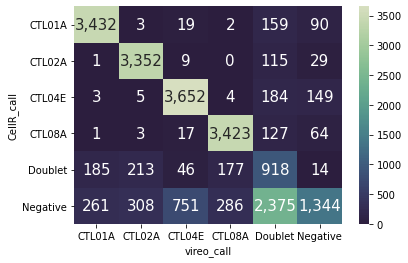

In [66]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["vireo_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Dropkick

In [67]:
dropkick_sample1 = pd.read_csv(genDem_folder + "test01/dropkick/dropkick_class.tsv", sep = "\t", index_col = 0)
dropkick_sample1

,dropkick_label_03
barcode,
AAACCCAAGATGCTGG-1,GoodQuality
AAACCCAAGCAAACAT-1,GoodQuality
AAACCCAAGCTACAAA-1,GoodQuality
AAACCCAAGGCGTCCT-1,GoodQuality
AAACCCAAGTAGTCAA-1,GoodQuality
...,...
TTTGTTGTCGCACGAC-1,LowQuality
TTTGTTGTCGCCATAA-1,GoodQuality
TTTGTTGTCTACTGCC-1,GoodQuality


In [68]:
dropkick_sample1["dropkick_label_03"].value_counts()

dropkick_label_03
GoodQuality    14734
LowQuality      7255
Name: count, dtype: int64

In [69]:
df_all_class_sample1 = df_all_class_sample1.merge(dropkick_sample1["dropkick_label_03"], how = "inner", left_index = True, right_index = True)

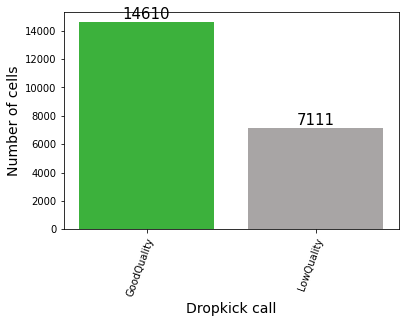

In [70]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.dropkick_label_03.value_counts().values, ax = ax,
            x = df_all_class_sample1.dropkick_label_03.value_counts().index.to_list(), palette=sd_palette)

labels = df_all_class_sample1.dropkick_label_03.value_counts().index.to_list()
values = df_all_class_sample1.dropkick_label_03.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Dropkick call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='dropkick_label_03', ylabel='MultiSeq_call'>

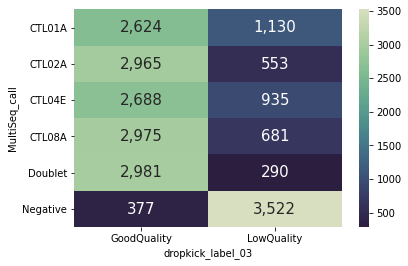

In [71]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["dropkick_label_03"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='dropkick_label_03', ylabel='CellR_call'>

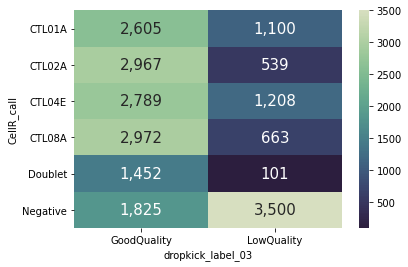

In [72]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["dropkick_label_03"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### scDblFinder

In [73]:
scdblfinder_sample1 = pd.read_csv(genDem_folder + "test01/scdblfinder/barcodesclass.tsv", sep = "\t", index_col = 0, header=None)
scdblfinder_sample1.columns = ["scdblfinder"]
scdblfinder_sample1

,scdblfinder
0,
AAACCCAAGATGCTGG-1,singlet
AAACCCAAGCAAACAT-1,singlet
AAACCCAAGCTACAAA-1,singlet
AAACCCAAGGCGTCCT-1,doublet
AAACCCAAGTAGTCAA-1,doublet
...,...
TTTGTTGTCGCACGAC-1,singlet
TTTGTTGTCGCCATAA-1,singlet
TTTGTTGTCTACTGCC-1,singlet


In [74]:
scdblfinder_sample1["scdblfinder"].value_counts()

scdblfinder
singlet    18609
doublet     3380
Name: count, dtype: int64

In [75]:
df_all_class_sample1 = df_all_class_sample1.merge(scdblfinder_sample1["scdblfinder"], how = "inner", left_index = True, right_index = True)

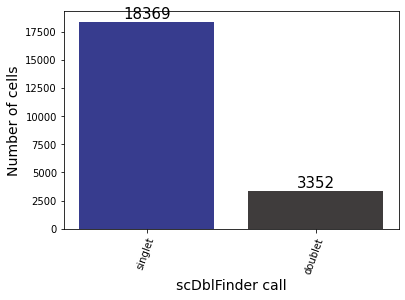

In [76]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.scdblfinder.value_counts().values, ax = ax,
            x = df_all_class_sample1.scdblfinder.value_counts().index.to_list(), palette=sd_palette)

labels = df_all_class_sample1.scdblfinder.value_counts().index.to_list()
values = df_all_class_sample1.scdblfinder.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("scDblFinder call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='scdblfinder', ylabel='MultiSeq_call'>

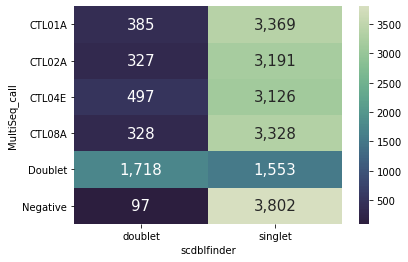

In [77]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["scdblfinder"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='scdblfinder', ylabel='CellR_call'>

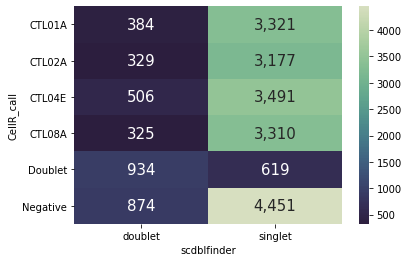

In [78]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["scdblfinder"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### AggregatedCall

In [79]:
aggCall_sample1 = pd.read_csv(genDem_folder + "test01/aggregatedCall/aggregatedCall.tsv", sep = "\t", index_col = 0)
aggCall_sample1

,Consensus
barcode,
AAACCCAAGATGCTGG-1,MIFF1
AAACCCAAGCAAACAT-1,809
AAACCCAAGCTACAAA-1,KOLF
AAACCCACAATCTCTT-1,809
AAACCCACACGGCACT-1,KOLF
...,...
TTTGGTTAGGTAGACC-1,LowQuality
TTTGGTTTCTCCGTGT-1,LowQuality
TTTGTTGAGGTAAGTT-1,LowQuality


In [80]:
aggCall_sample1["Consensus"].value_counts()

Consensus
809           5184
3391B         3924
doublet       3890
KOLF          3883
MIFF1         3789
LowQuality    1319
Name: count, dtype: int64

In [81]:
dbl_rate["Consensus"] = np.sum(aggCall_sample1["Consensus"] == "doublet") / aggCall_sample1.shape[0]
dbl_rate

{'Demuxlet': 0.25067078994042474,
 'SCanSNP': 0.1077356860248306,
 'SoC': 0.2242030105962072,
 'Vireo': 0.17936240847696575,
 'Consensus': 0.1769066351357497}

In [82]:
unassigned_rate["Consensus"] = np.sum(aggCall_sample1["Consensus"] == "LowQuality") / aggCall_sample1.shape[0]
unassigned_rate

{'Demuxlet': 0,
 'SCanSNP': 0,
 'SoC': 0.027923052435308564,
 'Vireo': 0.07913047432807313,
 'Consensus': 0.05998453772340716}

In [83]:
aggCall_sample1["Consensus"] = aggCall_sample1["Consensus"].map(old_names_map)
aggCall_sample1["Consensus"].value_counts()

Consensus
CTL04E      5184
CTL01A      3924
Doublet     3890
CTL08A      3883
CTL02A      3789
Negative    1319
Name: count, dtype: int64

In [84]:
aggCall_sample1["Consensus"].value_counts().sum()

21989

In [85]:
df_all_class_sample1 = df_all_class_sample1.merge(aggCall_sample1["Consensus"], how = "inner", left_index = True, right_index = True)

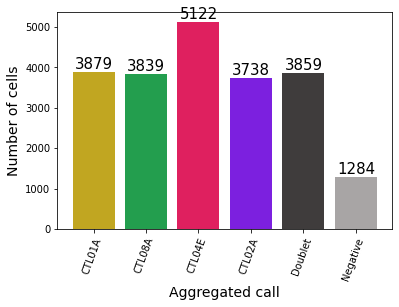

In [86]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample1.Consensus.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample1.Consensus.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample1.Consensus.value_counts().loc[order].index.to_list()
values = df_all_class_sample1.Consensus.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Aggregated call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='Consensus', ylabel='MultiSeq_call'>

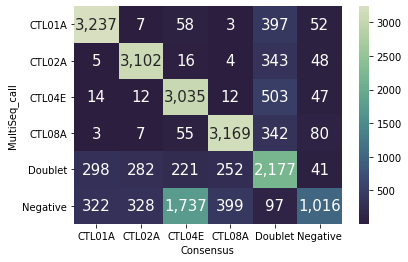

In [87]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["MultiSeq_call"], df_all_class_sample1["Consensus"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Consensus', ylabel='CellR_call'>

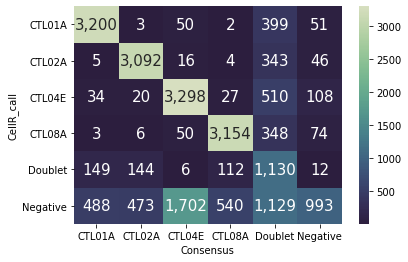

In [88]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample1["CellR_call"], df_all_class_sample1["Consensus"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

In [89]:
sample1_adata = sample1_adata[df_all_class_sample1.index]
sample1_adata

View of AnnData object with n_obs × n_vars = 21721 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

In [90]:
sample1_adata.obs = sample1_adata.obs.merge(df_all_class_sample1, right_index = True, left_index = True)
sample1_adata.obs

,Row,CMO301,CMO302,CMO303,CMO304,Multiplet,Blanks,Assignment,Assignment_Probability,MultiSeq_call,...,scansnp_call,scansnp_call_quality,Quality,scansnp_w_neg,scansnp_call_lowquality,souporcell_call,vireo_call,dropkick_label_03,scdblfinder,Consensus
AAACCCAAGATGCTGG-1,0,5.728910e-11,9.401407e-01,2.980659e-05,1.103714e-12,5.981833e-02,1.114560e-05,CTL02A,0.940141,CTL02A,...,CTL02A,CTL02A_GoodQuality,GoodQuality,CTL02A,CTL02A_GoodQuality,CTL02A,CTL02A,GoodQuality,singlet,CTL02A
AAACCCAAGCAAACAT-1,1,3.582631e-08,3.537087e-04,9.726013e-01,2.309623e-07,3.059255e-04,2.673885e-02,CTL04E,0.972601,CTL04E,...,CTL04E,CTL04E_GoodQuality,GoodQuality,CTL04E,CTL04E_GoodQuality,CTL04E,CTL04E,GoodQuality,singlet,CTL04E
AAACCCAAGCTACAAA-1,2,2.646026e-13,8.960614e-14,1.209593e-09,9.520157e-01,4.798431e-02,5.711508e-10,CTL08A,0.952016,CTL08A,...,CTL08A,CTL08A_GoodQuality,GoodQuality,CTL08A,CTL08A_GoodQuality,CTL08A,CTL08A,GoodQuality,singlet,CTL08A
AAACCCAAGGCGTCCT-1,3,4.801895e-04,1.278654e-09,5.418507e-13,1.291917e-19,9.995198e-01,2.248304e-14,Doublet,0.999520,Doublet,...,Doublet,Doublet_Doublet,Doublet,Doublet,Doublet_Doublet,Doublet,Doublet,GoodQuality,doublet,Doublet
AAACCCAAGTAGTCAA-1,4,3.489225e-01,6.953636e-14,2.623145e-09,3.820114e-17,6.510775e-01,3.328542e-11,Negative,0.651078,Doublet,...,Doublet,Doublet_Doublet,Doublet,Doublet,Doublet_Doublet,Doublet,Doublet,GoodQuality,doublet,Doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGGAGGCACGGTGAA-1,16982,2.419006e-06,6.036662e-05,8.994455e-01,1.774137e-06,1.374892e-05,1.004762e-01,CTL04E,0.899446,Negative,...,CTL04E,CTL04E_GoodQuality,GoodQuality,CTL04E,CTL04E_GoodQuality,CTL04E,CTL04E,LowQuality,singlet,CTL04E
TCATTTGCAATGACCT-1,18080,1.988383e-07,1.305540e-05,9.003259e-01,3.601130e-06,3.622748e-06,9.965364e-02,CTL04E,0.900326,Negative,...,CTL04E,CTL04E_GoodQuality,GoodQuality,CTL04E,CTL04E_GoodQuality,CTL04E,CTL04E,GoodQuality,singlet,CTL04E
TCCCATGAGCTCCCTT-1,18261,7.522078e-05,1.313040e-04,8.998805e-01,2.412172e-06,4.479241e-05,9.986572e-02,CTL04E,0.899881,Negative,...,CTL04E,CTL04E_GoodQuality,GoodQuality,CTL04E,CTL04E_GoodQuality,Doublet,CTL04E,LowQuality,singlet,Negative
TCGATTTTCCCTTGTG-1,18650,2.201159e-09,7.095028e-07,9.003435e-01,8.697309e-10,1.531538e-07,9.965559e-02,CTL04E,0.900344,CTL04E,...,CTL02A,CTL02A_LowQuality,LowQuality,Negative,CTL02A_LowQuality,Doublet,Doublet,LowQuality,singlet,CTL04E


# Save outputs

In [91]:
sample1_adata

AnnData object with n_obs × n_vars = 21721 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability', 'MultiSeq_call', 'CellR_call', 'demux_v1_call', 'demux_v2_call', 'scansnp_call', 'scansnp_call_quality', 'Quality', 'scansnp_w_neg', 'scansnp_call_lowquality', 'souporcell_call', 'vireo_call', 'dropkick_label_03', 'scdblfinder', 'Consensus'
    var: 'gene_ids', 'feature_types', 'genome'

In [92]:
sample1_adata.write(homeDir+"/data/cellplexDS/adatas/sample1_withClass.h5ad")

In [93]:
df_all_class_sample1.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/sample1_allCalls.csv")

# Accuracy before filtering for neg and doublets

## Precision of genetic demultiplexing tools vs Genetic Consensus, MultiSeq and Cell Ranger classifications

The precision is the ratio `tp / (tp + fp)`

### Testing against MultiSeq call:

In [94]:
precision = {}
sub_precision = df_all_class_sample1
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")

In [95]:
precision_df = pd.DataFrame(precision, index = ["MultiSeq"])
precision_df

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq,0.602939,0.757949,0.785375,0.84494,0.743397


In [96]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = df_all_class_sample1[~df_all_class_sample1[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq"])
precision_df2.columns = precision_df2.columns + "_no_neg_doub"

precision_df2

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
MultiSeq,0.681499,0.710611,0.72645,0.747536,0.593765


In [97]:
precision_df = pd.concat([precision_df.T,precision_df2.T])
precision_df

,MultiSeq
demux_v2_call,0.602939
souporcell_call,0.757949
vireo_call,0.785375
scansnp_w_neg,0.844940
Consensus,0.743397
demux_v2_call_no_neg_doub,0.681499
souporcell_call_no_neg_doub,0.710611
vireo_call_no_neg_doub,0.726450
scansnp_w_neg_no_neg_doub,0.747536
Consensus_no_neg_doub,0.593765


Removing Negative cells from Multi Seq call:

In [98]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Negative"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")

In [99]:
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_negative"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative,0.845753,0.85729,0.875336,0.919724,0.848713


In [100]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_negative"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [101]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_negative
demux_v2_call,0.845753
souporcell_call,0.857290
vireo_call,0.875336
scansnp_w_neg,0.919724
Consensus,0.848713
demux_v2_call_no_neg_doub,0.807110
souporcell_call_no_neg_doub,0.829334
vireo_call_no_neg_doub,0.843855
scansnp_w_neg_no_neg_doub,0.867814
Consensus_no_neg_doub,0.870982


In [102]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative
demux_v2_call,0.602939,0.845753
souporcell_call,0.757949,0.857290
vireo_call,0.785375,0.875336
scansnp_w_neg,0.844940,0.919724
Consensus,0.743397,0.848713
demux_v2_call_no_neg_doub,0.681499,0.807110
souporcell_call_no_neg_doub,0.710611,0.829334
vireo_call_no_neg_doub,0.726450,0.843855
scansnp_w_neg_no_neg_doub,0.747536,0.867814
Consensus_no_neg_doub,0.593765,0.870982


Removing doublet cells from Multi Seq call:

In [103]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_doublet,0.714662,0.90667,0.917461,0.895254,0.824473


In [104]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_doublet"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [105]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_doublet
demux_v2_call,0.714662
souporcell_call,0.906670
vireo_call,0.917461
scansnp_w_neg,0.895254
Consensus,0.824473
demux_v2_call_no_neg_doub,0.822321
souporcell_call_no_neg_doub,0.900621
vireo_call_no_neg_doub,0.915908
scansnp_w_neg_no_neg_doub,0.918115
Consensus_no_neg_doub,0.915503


In [106]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet
demux_v2_call,0.602939,0.845753,0.714662
souporcell_call,0.757949,0.857290,0.906670
vireo_call,0.785375,0.875336,0.917461
scansnp_w_neg,0.844940,0.919724,0.895254
Consensus,0.743397,0.848713,0.824473
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621
vireo_call_no_neg_doub,0.726450,0.843855,0.915908
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115
Consensus_no_neg_doub,0.593765,0.870982,0.915503


Removing both Negative and Doublet:

In [107]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Negative", "Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_negative_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative_no_doublet,0.990098,0.99305,0.994841,0.994071,0.9846


In [108]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_negative_no_doublet"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [109]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_negative_no_doublet
demux_v2_call,0.990098
souporcell_call,0.993050
vireo_call,0.994841
scansnp_w_neg,0.994071
Consensus,0.984600
demux_v2_call_no_neg_doub,0.990118
souporcell_call_no_neg_doub,0.995210
vireo_call_no_neg_doub,0.996293
scansnp_w_neg_no_neg_doub,0.996465
Consensus_no_neg_doub,0.996408


In [110]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet
demux_v2_call,0.602939,0.845753,0.714662,0.990098
souporcell_call,0.757949,0.857290,0.906670,0.993050
vireo_call,0.785375,0.875336,0.917461,0.994841
scansnp_w_neg,0.844940,0.919724,0.895254,0.994071
Consensus,0.743397,0.848713,0.824473,0.984600
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321,0.990118
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621,0.995210
vireo_call_no_neg_doub,0.726450,0.843855,0.915908,0.996293
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115,0.996465
Consensus_no_neg_doub,0.593765,0.870982,0.915503,0.996408


### Testing against CellRanger multi output

In [111]:
sub_precision = df_all_class_sample1
#sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["nan"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger"])

precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = df_all_class_sample1[~df_all_class_sample1[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger,0.69616,0.724918,0.74058,0.763074,0.607971


In [112]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger
demux_v2_call,0.580696
souporcell_call,0.782638
vireo_call,0.798672
scansnp_w_neg,0.809094
Consensus,0.740735
demux_v2_call_no_neg_doub,0.696160
souporcell_call_no_neg_doub,0.724918
vireo_call_no_neg_doub,0.740580
scansnp_w_neg_no_neg_doub,0.763074
Consensus_no_neg_doub,0.607971


In [113]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger
demux_v2_call,0.602939,0.845753,0.714662,0.990098,0.580696
souporcell_call,0.757949,0.857290,0.906670,0.993050,0.782638
vireo_call,0.785375,0.875336,0.917461,0.994841,0.798672
scansnp_w_neg,0.844940,0.919724,0.895254,0.994071,0.809094
Consensus,0.743397,0.848713,0.824473,0.984600,0.740735
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321,0.990118,0.696160
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621,0.995210,0.724918
vireo_call_no_neg_doub,0.726450,0.843855,0.915908,0.996293,0.740580
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115,0.996465,0.763074
Consensus_no_neg_doub,0.593765,0.870982,0.915503,0.996408,0.607971


Removing Negative cells from CellRanger call:

In [114]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Negative"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_negative"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative,0.90362,0.909624,0.920708,0.952597,0.901989


In [115]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_negative"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative,0.912284,0.926111,0.933293,0.944324,0.945296


In [116]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_negative
demux_v2_call,0.903620
souporcell_call,0.909624
vireo_call,0.920708
scansnp_w_neg,0.952597
Consensus,0.901989
demux_v2_call_no_neg_doub,0.912284
souporcell_call_no_neg_doub,0.926111
vireo_call_no_neg_doub,0.933293
scansnp_w_neg_no_neg_doub,0.944324
Consensus_no_neg_doub,0.945296


In [117]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative
demux_v2_call,0.602939,0.845753,0.714662,0.990098,0.580696,0.903620
souporcell_call,0.757949,0.857290,0.906670,0.993050,0.782638,0.909624
vireo_call,0.785375,0.875336,0.917461,0.994841,0.798672,0.920708
scansnp_w_neg,0.844940,0.919724,0.895254,0.994071,0.809094,0.952597
Consensus,0.743397,0.848713,0.824473,0.984600,0.740735,0.901989
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321,0.990118,0.696160,0.912284
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621,0.995210,0.724918,0.926111
vireo_call_no_neg_doub,0.726450,0.843855,0.915908,0.996293,0.740580,0.933293
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115,0.996465,0.763074,0.944324
Consensus_no_neg_doub,0.593765,0.870982,0.915503,0.996408,0.607971,0.945296


Removing doublet cells from CellRanger call:

In [118]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_doublet"])

precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_doublet"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_doublet,0.749353,0.824976,0.845525,0.861102,0.861491


In [119]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_doublet
demux_v2_call,0.634876
souporcell_call,0.857020
vireo_call,0.869744
scansnp_w_neg,0.857407
Consensus,0.793566
demux_v2_call_no_neg_doub,0.749353
souporcell_call_no_neg_doub,0.824976
vireo_call_no_neg_doub,0.845525
scansnp_w_neg_no_neg_doub,0.861102
Consensus_no_neg_doub,0.861491


In [120]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet
demux_v2_call,0.602939,0.845753,0.714662,0.990098,0.580696,0.903620,0.634876
souporcell_call,0.757949,0.857290,0.906670,0.993050,0.782638,0.909624,0.857020
vireo_call,0.785375,0.875336,0.917461,0.994841,0.798672,0.920708,0.869744
scansnp_w_neg,0.844940,0.919724,0.895254,0.994071,0.809094,0.952597,0.857407
Consensus,0.743397,0.848713,0.824473,0.984600,0.740735,0.901989,0.793566
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321,0.990118,0.696160,0.912284,0.749353
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621,0.995210,0.724918,0.926111,0.824976
vireo_call_no_neg_doub,0.726450,0.843855,0.915908,0.996293,0.740580,0.933293,0.845525
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115,0.996465,0.763074,0.944324,0.861102
Consensus_no_neg_doub,0.593765,0.870982,0.915503,0.996408,0.607971,0.945296,0.861491


Removing both Negative and Doublet:

In [121]:
sub_precision = df_all_class_sample1
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Negative", "Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_negative_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative_no_doublet,0.9899,0.992642,0.995158,0.993941,0.982886


In [122]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_negative_no_doublet"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative_no_doublet,0.990034,0.9951,0.996621,0.996644,0.996603


In [123]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_negative_no_doublet
demux_v2_call,0.989900
souporcell_call,0.992642
vireo_call,0.995158
scansnp_w_neg,0.993941
Consensus,0.982886
demux_v2_call_no_neg_doub,0.990034
souporcell_call_no_neg_doub,0.995100
vireo_call_no_neg_doub,0.996621
scansnp_w_neg_no_neg_doub,0.996644
Consensus_no_neg_doub,0.996603


In [124]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet,CellRanger_no_negative_no_doublet
demux_v2_call,0.602939,0.845753,0.714662,0.990098,0.580696,0.903620,0.634876,0.989900
souporcell_call,0.757949,0.857290,0.906670,0.993050,0.782638,0.909624,0.857020,0.992642
vireo_call,0.785375,0.875336,0.917461,0.994841,0.798672,0.920708,0.869744,0.995158
scansnp_w_neg,0.844940,0.919724,0.895254,0.994071,0.809094,0.952597,0.857407,0.993941
Consensus,0.743397,0.848713,0.824473,0.984600,0.740735,0.901989,0.793566,0.982886
demux_v2_call_no_neg_doub,0.681499,0.807110,0.822321,0.990118,0.696160,0.912284,0.749353,0.990034
souporcell_call_no_neg_doub,0.710611,0.829334,0.900621,0.995210,0.724918,0.926111,0.824976,0.995100
vireo_call_no_neg_doub,0.726450,0.843855,0.915908,0.996293,0.740580,0.933293,0.845525,0.996621
scansnp_w_neg_no_neg_doub,0.747536,0.867814,0.918115,0.996465,0.763074,0.944324,0.861102,0.996644
Consensus_no_neg_doub,0.593765,0.870982,0.915503,0.996408,0.607971,0.945296,0.861491,0.996603


In [125]:
precision_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/precision_sample1.csv")

## Recall of genetic demultiplexing tools vs Genetic Consensus, MultiSeq and Cell Ranger classifications

### Testing against MultiSeq call:

In [126]:
recall = {}
sub_recall = df_all_class_sample1
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df = pd.DataFrame(recall, index = ["MultiSeq"])
recall_df

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq,0.698541,0.727683,0.774872,0.841858,0.72446


In [127]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = df_all_class_sample1[~df_all_class_sample1[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq"])
recall_df2.columns = recall_df2.columns + "_no_neg_doub"
recall_df2

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
MultiSeq,0.818349,0.838817,0.848387,0.859899,0.756605


In [128]:
recall_df = pd.concat([recall_df.T,recall_df2.T])
recall_df

,MultiSeq
demux_v2_call,0.698541
souporcell_call,0.727683
vireo_call,0.774872
scansnp_w_neg,0.841858
Consensus,0.724460
demux_v2_call_no_neg_doub,0.818349
souporcell_call_no_neg_doub,0.838817
vireo_call_no_neg_doub,0.848387
scansnp_w_neg_no_neg_doub,0.859899
Consensus_no_neg_doub,0.756605


Removing Negative cells from Multi Seq call:

In [129]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Negative"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_negative"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative,0.851363,0.860453,0.866794,0.87117,0.825945


In [130]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_negative"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_negative
demux_v2_call,0.851363
souporcell_call,0.860453
vireo_call,0.866794
scansnp_w_neg,0.871170
Consensus,0.825945
demux_v2_call_no_neg_doub,0.893835
souporcell_call_no_neg_doub,0.908473
vireo_call_no_neg_doub,0.916888
scansnp_w_neg_no_neg_doub,0.929906
Consensus_no_neg_doub,0.931568


In [131]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative
demux_v2_call,0.698541,0.851363
souporcell_call,0.727683,0.860453
vireo_call,0.774872,0.866794
scansnp_w_neg,0.841858,0.871170
Consensus,0.724460,0.825945
demux_v2_call_no_neg_doub,0.818349,0.893835
souporcell_call_no_neg_doub,0.838817,0.908473
vireo_call_no_neg_doub,0.848387,0.916888
scansnp_w_neg_no_neg_doub,0.859899,0.929906
Consensus_no_neg_doub,0.756605,0.931568


Removing doublet cells from Multi Seq call:

In [132]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_doublet,0.72374,0.766233,0.817724,0.879133,0.734905


In [133]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_doublet"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_doublet
demux_v2_call,0.723740
souporcell_call,0.766233
vireo_call,0.817724
scansnp_w_neg,0.879133
Consensus,0.734905
demux_v2_call_no_neg_doub,0.898224
souporcell_call_no_neg_doub,0.945409
vireo_call_no_neg_doub,0.954168
scansnp_w_neg_no_neg_doub,0.955468
Consensus_no_neg_doub,0.953916


In [134]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet
demux_v2_call,0.698541,0.851363,0.723740
souporcell_call,0.727683,0.860453,0.766233
vireo_call,0.774872,0.866794,0.817724
scansnp_w_neg,0.841858,0.871170,0.879133
Consensus,0.724460,0.825945,0.734905
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409
vireo_call_no_neg_doub,0.848387,0.916888,0.954168
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468
Consensus_no_neg_doub,0.756605,0.931568,0.953916


Removing both Negative and Doublet:

In [135]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Negative", "Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_negative_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative_no_doublet,0.917669,0.939179,0.941791,0.925022,0.862003


In [136]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_negative_no_doublet"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_negative_no_doublet
demux_v2_call,0.917669
souporcell_call,0.939179
vireo_call,0.941791
scansnp_w_neg,0.925022
Consensus,0.862003
demux_v2_call_no_neg_doub,0.989991
souporcell_call_no_neg_doub,0.995186
vireo_call_no_neg_doub,0.996272
scansnp_w_neg_no_neg_doub,0.996445
Consensus_no_neg_doub,0.996383


In [137]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet
demux_v2_call,0.698541,0.851363,0.723740,0.917669
souporcell_call,0.727683,0.860453,0.766233,0.939179
vireo_call,0.774872,0.866794,0.817724,0.941791
scansnp_w_neg,0.841858,0.871170,0.879133,0.925022
Consensus,0.724460,0.825945,0.734905,0.862003
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224,0.989991
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409,0.995186
vireo_call_no_neg_doub,0.848387,0.916888,0.954168,0.996272
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468,0.996445
Consensus_no_neg_doub,0.756605,0.931568,0.953916,0.996383


### Testing against CellRanger multi output

In [138]:
sub_recall = df_all_class_sample1
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger"])
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = df_all_class_sample1[~df_all_class_sample1[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
recall_df3 = pd.DataFrame(recall, index = ["CellRanger"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger,0.828829,0.848024,0.857983,0.870185,0.76873


In [139]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger
demux_v2_call,0.667833
souporcell_call,0.698679
vireo_call,0.742185
scansnp_w_neg,0.803186
Consensus,0.684453
demux_v2_call_no_neg_doub,0.828829
souporcell_call_no_neg_doub,0.848024
vireo_call_no_neg_doub,0.857983
scansnp_w_neg_no_neg_doub,0.870185
Consensus_no_neg_doub,0.768730


In [140]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger
demux_v2_call,0.698541,0.851363,0.723740,0.917669,0.667833
souporcell_call,0.727683,0.860453,0.766233,0.939179,0.698679
vireo_call,0.774872,0.866794,0.817724,0.941791,0.742185
scansnp_w_neg,0.841858,0.871170,0.879133,0.925022,0.803186
Consensus,0.724460,0.825945,0.734905,0.862003,0.684453
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224,0.989991,0.828829
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409,0.995186,0.848024
vireo_call_no_neg_doub,0.848387,0.916888,0.954168,0.996272,0.857983
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468,0.996445,0.870185
Consensus_no_neg_doub,0.756605,0.931568,0.953916,0.996383,0.768730


Removing Negative cells from CellRanger call:

In [141]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Negative"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_negative"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative,0.884728,0.897597,0.901256,0.896743,0.846182


In [142]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_negative"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative,0.950253,0.959879,0.964351,0.970058,0.970532


In [143]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_negative
demux_v2_call,0.884728
souporcell_call,0.897597
vireo_call,0.901256
scansnp_w_neg,0.896743
Consensus,0.846182
demux_v2_call_no_neg_doub,0.950253
souporcell_call_no_neg_doub,0.959879
vireo_call_no_neg_doub,0.964351
scansnp_w_neg_no_neg_doub,0.970058
Consensus_no_neg_doub,0.970532


In [144]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative
demux_v2_call,0.698541,0.851363,0.723740,0.917669,0.667833,0.884728
souporcell_call,0.727683,0.860453,0.766233,0.939179,0.698679,0.897597
vireo_call,0.774872,0.866794,0.817724,0.941791,0.742185,0.901256
scansnp_w_neg,0.841858,0.871170,0.879133,0.925022,0.803186,0.896743
Consensus,0.724460,0.825945,0.734905,0.862003,0.684453,0.846182
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224,0.989991,0.828829,0.950253
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409,0.995186,0.848024,0.959879
vireo_call_no_neg_doub,0.848387,0.916888,0.954168,0.996272,0.857983,0.964351
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468,0.996445,0.870185,0.970058
Consensus_no_neg_doub,0.756605,0.931568,0.953916,0.996383,0.768730,0.970532


Removing doublet cells from CellRanger call:

In [145]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_doublet"])
recall = {}

for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_doublet"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_doublet,0.858885,0.905423,0.917464,0.926052,0.926246


In [146]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_doublet
demux_v2_call,0.670567
souporcell_call,0.707804
vireo_call,0.753818
scansnp_w_neg,0.811384
Consensus,0.681129
demux_v2_call_no_neg_doub,0.858885
souporcell_call_no_neg_doub,0.905423
vireo_call_no_neg_doub,0.917464
scansnp_w_neg_no_neg_doub,0.926052
Consensus_no_neg_doub,0.926246


In [147]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet
demux_v2_call,0.698541,0.851363,0.723740,0.917669,0.667833,0.884728,0.670567
souporcell_call,0.727683,0.860453,0.766233,0.939179,0.698679,0.897597,0.707804
vireo_call,0.774872,0.866794,0.817724,0.941791,0.742185,0.901256,0.753818
scansnp_w_neg,0.841858,0.871170,0.879133,0.925022,0.803186,0.896743,0.811384
Consensus,0.724460,0.825945,0.734905,0.862003,0.684453,0.846182,0.681129
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224,0.989991,0.828829,0.950253,0.858885
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409,0.995186,0.848024,0.959879,0.905423
vireo_call_no_neg_doub,0.848387,0.916888,0.954168,0.996272,0.857983,0.964351,0.917464
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468,0.996445,0.870185,0.970058,0.926052
Consensus_no_neg_doub,0.756605,0.931568,0.953916,0.996383,0.768730,0.970532,0.926246


Removing both Negative and Doublet:

In [148]:
sub_recall = df_all_class_sample1
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Negative", "Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_negative_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative_no_doublet,0.911137,0.930809,0.933706,0.917672,0.858587


In [149]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_negative_no_doublet"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative_no_doublet,0.989971,0.995089,0.99661,0.996633,0.996591


In [150]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_negative_no_doublet
demux_v2_call,0.911137
souporcell_call,0.930809
vireo_call,0.933706
scansnp_w_neg,0.917672
Consensus,0.858587
demux_v2_call_no_neg_doub,0.989971
souporcell_call_no_neg_doub,0.995089
vireo_call_no_neg_doub,0.996610
scansnp_w_neg_no_neg_doub,0.996633
Consensus_no_neg_doub,0.996591


In [151]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet,CellRanger_no_negative_no_doublet
demux_v2_call,0.698541,0.851363,0.723740,0.917669,0.667833,0.884728,0.670567,0.911137
souporcell_call,0.727683,0.860453,0.766233,0.939179,0.698679,0.897597,0.707804,0.930809
vireo_call,0.774872,0.866794,0.817724,0.941791,0.742185,0.901256,0.753818,0.933706
scansnp_w_neg,0.841858,0.871170,0.879133,0.925022,0.803186,0.896743,0.811384,0.917672
Consensus,0.724460,0.825945,0.734905,0.862003,0.684453,0.846182,0.681129,0.858587
demux_v2_call_no_neg_doub,0.818349,0.893835,0.898224,0.989991,0.828829,0.950253,0.858885,0.989971
souporcell_call_no_neg_doub,0.838817,0.908473,0.945409,0.995186,0.848024,0.959879,0.905423,0.995089
vireo_call_no_neg_doub,0.848387,0.916888,0.954168,0.996272,0.857983,0.964351,0.917464,0.996610
scansnp_w_neg_no_neg_doub,0.859899,0.929906,0.955468,0.996445,0.870185,0.970058,0.926052,0.996633
Consensus_no_neg_doub,0.756605,0.931568,0.953916,0.996383,0.768730,0.970532,0.926246,0.996591


In [152]:
recall_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/recall_sample1.csv")

# Save

In [153]:
dbl_rate_df = pd.DataFrame(dbl_rate.items())
dbl_rate_df.columns = ["Software", "Doublet_Rate"]
dbl_rate_df["Unassigned_rate"] = unassigned_rate.values()

In [154]:
dbl_rate_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/sample1_DoubletSinglet_rates.csv")